In [3]:
!pip -V

pip 23.3.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [6]:
!pip list | grep clip

clip                      1.0


In [ ]:
# !pip install git+https://github.com/mhamilton723/FeatUp.git

# .init

In [1]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Dino v2 upsampler

In [2]:
import matplotlib.pyplot as plt
from featup.util import pca, remove_axes
from featup.featurizers.maskclip.clip import tokenize
from pytorch_lightning import seed_everything
import torch
import torch.nn.functional as F


@torch.no_grad()
def plot_feats_pca(image, lr, hr, fit_pca = None):
    assert len(image.shape) == len(lr.shape) == len(hr.shape) == 3
    seed_everything(0)
    [lr_feats_pca, hr_feats_pca], fit_pca = pca([lr.unsqueeze(0), hr.unsqueeze(0)], fit_pca = fit_pca)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.permute(1, 2, 0).detach().cpu())
    ax[0].set_title("Image")
    ax[1].imshow(lr_feats_pca[0].permute(1, 2, 0).detach().cpu())
    ax[1].set_title("Original Features")
    ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
    ax[2].set_title("Upsampled Features")
    remove_axes(ax)
    plt.show()
    return fit_pca


In [3]:
use_norm = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

upsampler = torch.hub.load("mhamilton723/FeatUp",
                           'dinov2', use_norm=use_norm).to(device)

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/opt/conda/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/opt/conda/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/opt/conda/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning:

## Patch utils

In [4]:
import numpy as np

def extract_patch(image: Image, x, y, width, height):
  """
  Extracts a patch from the given image.

  Args:
    image: The PIL Image object.
    x: The x-coordinate of the top-left corner of the patch.
    y: The y-coordinate of the top-left corner of the patch.
    width: The width of the patch.
    height: The height of the patch.

  Returns:
    The extracted patch as a PIL Image object.
  """
  patch = image.crop((x, y, x + width, y + height))
  return patch


def extract_patches_numpy(image, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом.

    :param image: Исходное изображение (numpy array).
    :param patch_size: Размер патча (высота, ширина).
    :param step: Шаг (по вертикали и горизонтали).
    :return: Список патчей.
    """
    patches = []
    height, width = image.shape[:2]
    patch_height, patch_width = patch_size

    for y in range(0, height - patch_height + 1, step):
        for x in range(0, width - patch_width + 1, step):
            patch = image[y:y + patch_height, x:x + patch_width]
            patches.append(patch)

    return patches

def extract_patches_pillow(image: Image, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом.

    :param image: Исходное изображение (Pillow Image).
    :param patch_size: Размер патча (ширина, высота).
    :param step: Шаг (по горизонтали и вертикали).
    :return: Список патчей (Pillow Images).
    """
    patches = []
    width, height = image.size
    patch_width, patch_height = patch_size


    for y in range(0, height - patch_height + 1, step):
        for x in range(0, width - patch_width + 1, step):
            patch = image.crop((x, y, x + patch_width, y + patch_height))
            patches.append(patch)

    return patches


def extract_patches_pillow_matrix(image: Image, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом по x и y.

    :param image: Исходное изображение (Pillow Image).
    :param patch_size: Размер патча (ширина, высота).
    :param step_x: Шаг по горизонтали.
    :param step_y: Шаг по вертикали.
    :return: Двумерная матрица патчей (numpy array).
    """
    patches = []
    width, height = image.size
    patch_width, patch_height = patch_size

    step_x, step_y = step

    for y in range(0, height - patch_height + 1, step_y):
        row_patches = []
        for x in range(0, width - patch_width + 1, step_x):
            patch = image.crop((x, y, x + patch_width, y + patch_height))
            row_patches.append(np.array(patch))
        patches.append(row_patches)

    return np.array(patches)

# Image 

In [47]:
# patch_size = 112 #224
# overlap = 12 #24
patch_size = 256/2
overlap = 26/2

step = patch_size - overlap


transform = T.Compose([
    T.Resize(256),
    T.CenterCrop((256, 256)),
    T.ToTensor(),
    norm
])

## Load images

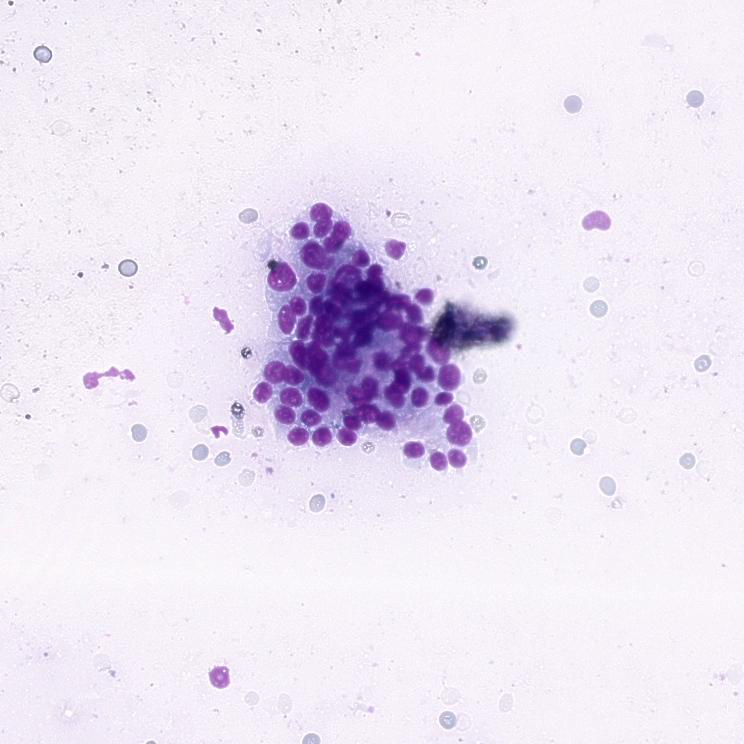

In [44]:
# image_path = '/root/feature-map-experiments/assets/c16-part1.png'
image_path = '/root/feature-map-experiments/assets/UT_cytopathology_213_239_roi_7333.jpeg'
image = Image.open(image_path).convert("RGB")
image

In [45]:
# patches = extract_patches_pillow(image, patch_size=(patch_size, patch_size), step=patch_size-overlap)
# len(patches)

In [46]:
patches_mat = extract_patches_pillow_matrix(image, patch_size=(patch_size, patch_size), step=(step,step))
patches_mat.shape

TypeError: 'float' object cannot be interpreted as an integer

### Just code snippets

In [9]:
import numpy as np
# Создаем 5-мерный тензор
tensor = np.random.rand(3, 3, 5, 5, 3)

# Сглаживаем оси 2 и 3
flattened_tensor = tensor.reshape(-1, *tensor.shape[2:])
flattened_tensor.shape

(9, 5, 5, 3)

# Draw Patches Grid

In [10]:
import matplotlib.pyplot as plt


def display_image_grid(flat_images, grid_size, figsize=(10, 10)):
    """
    Выводит матрицу изображений заданного размера.

    :param images: Список изображений (numpy arrays).
    :param grid_size: Размер сетки (строки, столбцы).
    :param figsize: Размер фигуры.
    """
    num_rows, num_cols = grid_size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        if i < len(flat_images):
            ax.imshow(flat_images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    

In [11]:
patches_mat.shape[0:2]

(7, 7)

In [12]:
patches_mat_shape = patches_mat.shape[0:2]
flat_patches_mat = patches_mat.reshape(-1, *patches_mat.shape[2:])

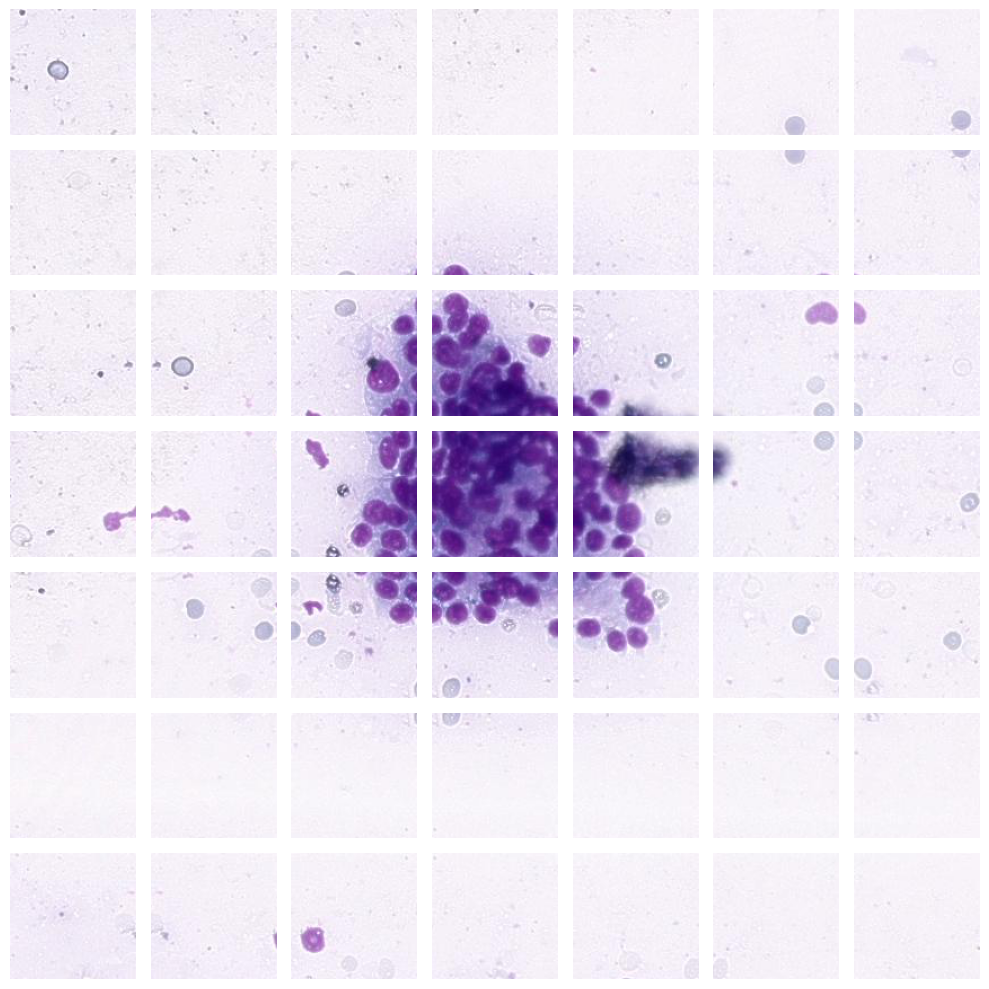

In [13]:
display_image_grid(flat_patches_mat, patches_mat_shape)

In [14]:


# image2 = extract_patch(image, 450, 550, 224, 224)
# image2 = extract_patch(image, 350, 100, 224, 224)
# image2 = extract_patch(image, 300, 150, 112, 112)

# image2

In [15]:
image_tensor = transform(Image.fromarray(flat_patches_mat[4])).unsqueeze(0).to(device)

# Process using upsampler

## Just pre-experiments

Seed set to 0


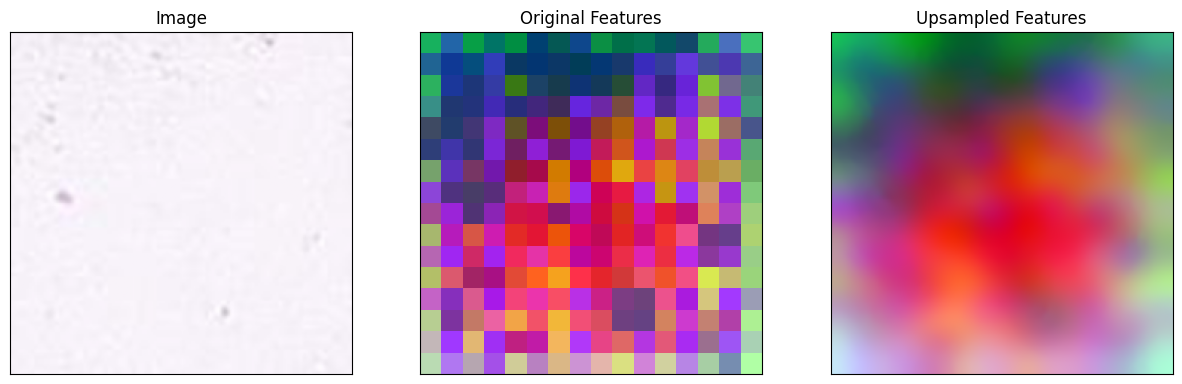

In [50]:

hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
fit_pca = plot_feats_pca(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [51]:
print(f'{hr_feats.shape=} {lr_feats.shape=}')

hr_feats.shape=torch.Size([1, 384, 256, 256]) lr_feats.shape=torch.Size([1, 384, 16, 16])


## Mass processing

In [16]:
image_tensors = [transform(Image.fromarray(p)) for p in flat_patches_mat]
image_tensors = torch.stack(image_tensors).to(device)

In [17]:
image_tensors.shape

torch.Size([49, 3, 224, 224])

In [35]:
tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([4, 5, 6])
tensor3 = torch.tensor([7, 8, 9])

# Объединение тензоров вдоль новой оси
stacked_tensor = torch.stack([tensor1, tensor2, tensor3], dim=1).flatten()

print(stacked_tensor)

TypeError: 'list' object cannot be interpreted as an integer

In [33]:
tensor1 = np.array([[1, 2, 3]])
tensor2 = np.array([[4, 5, 6]])
tensor3 = np.array([[7, 8, 9]])

# Объединение тензоров вдоль новой оси
stacked_tensor = np.stack([tensor1, tensor2, tensor3]).flatten()

print(stacked_tensor)

[1 2 3 4 5 6 7 8 9]


In [38]:
batch_size = 3
# hr_feats = upsampler(image_tensors)
# lr_feats = upsampler.model(image_tensors)


hr_feats_list = []
lr_feats_list = []
num_elements = image_tensors.shape[0]

for start in range(0, num_elements, batch_size):
    end = min(start + batch_size, num_elements)
    batch = image_tensors[start:end]
    print(f'{batch.shape=}')

    with torch.no_grad():
        hr_feats_list.append(upsampler(batch).cpu())
        lr_feats_list.append(upsampler.model(batch).cpu())

    torch.cuda.empty_cache()

lr_feats_list = torch.cat(lr_feats_list, dim=0)
hr_feats_list = torch.cat(hr_feats_list, dim=0)

print(f'{lr_feats_list.shape=}  {hr_feats_list.shape=}')

batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([3, 3, 224, 224])
batch.shape=torch.Size([1, 3, 224, 224])
lr_feats_list.shape=torch.Size([49, 384, 16, 16])  hr_feats_list.shape=torch.Size([49, 384, 256, 256])


In [18]:
# fit_pca = None
unn_image_tensors = unnorm(image_tensors)
for i in range(3):
    fit_pca = plot_feats_pca(unn_image_tensors[i], lr_feats[i], hr_feats[i], fit_pca = fit_pca)

NameError: name 'fit_pca' is not defined

## PCA on image features

Seed set to 0


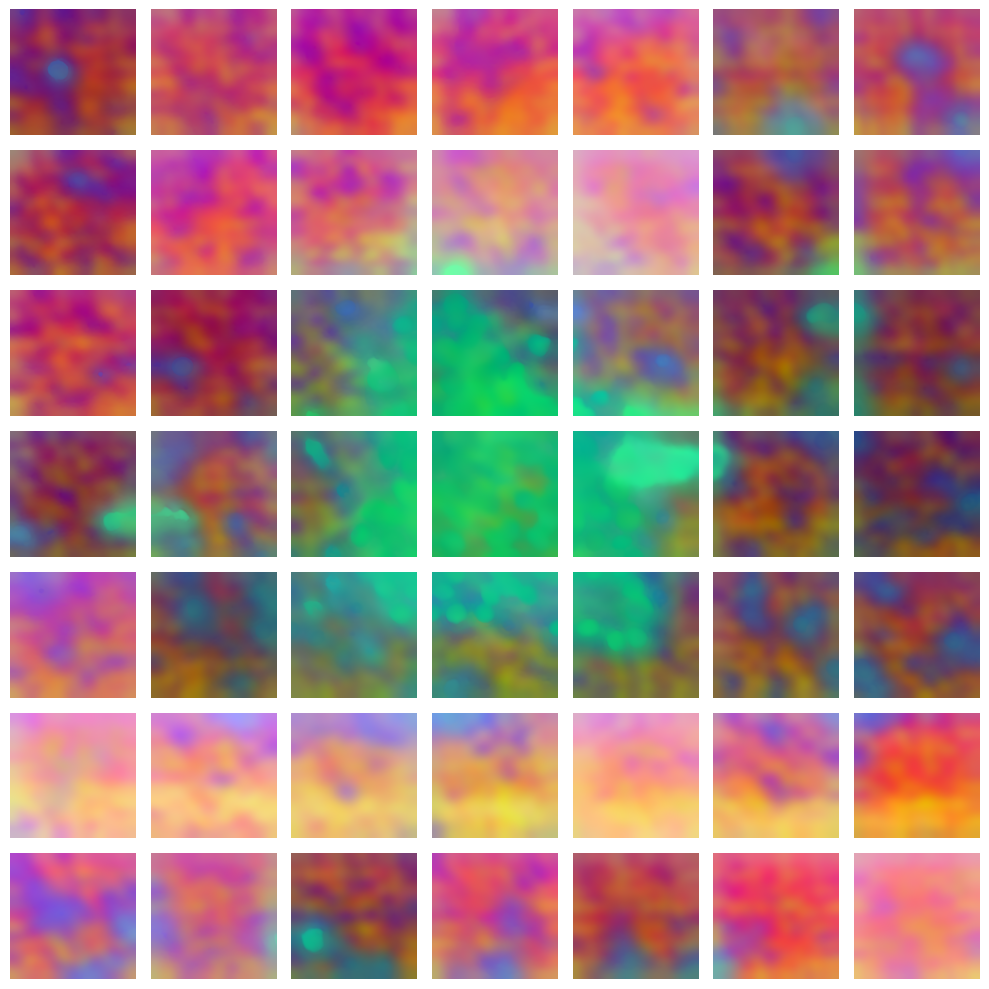

In [39]:
seed_everything(0)
[lr_feats_pca, hr_feats_pca], fit_pca = pca(
    [lr_feats_list, hr_feats_list], fit_pca=None)

# ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
hr_feats_pca_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_pca]

display_image_grid(hr_feats_pca_arr, patches_mat_shape)

In [40]:
hr_feats_pca_flat = np.stack(hr_feats_pca_arr)
hr_feats_pca_flat.shape

(49, 256, 256, 3)

In [41]:
hr_feats_mat = hr_feats_pca_flat.reshape(
    patches_mat_shape[0], patches_mat_shape[1], *hr_feats_pca_flat.shape[1:])

hr_feats_mat.shape

(7, 7, 256, 256, 3)

In [28]:
# Создаем 5-мерный тензор
tensor = np.random.rand(3, 3, 5, 5, 3)
olap = 2
m1 = tensor[1, 1]
print(f'{m1.shape=}')

m1[-olap:,:].shape

m1.shape=(5, 5, 3)


(2, 5, 3)

In [30]:
np.linspace(1, 0, olap*3).reshape(-1, 1, 3)

array([[[1. , 0.8, 0.6]],

       [[0.4, 0.2, 0. ]]])

# Merge and blend patches

In [42]:
def linear_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width, masks.shape[-1]), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= np.linspace(0, 1, overlap*3).reshape(-1, 1, 3)
            if j > 0:
                patch_mask[:, :overlap] *= np.linspace(0, 1, overlap*3).reshape(-1,3)
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= np.linspace(1, 0, overlap*3).reshape(-1, 1, 3)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= np.linspace(1, 0, overlap*3).reshape(-1,3)

            print(
                f'{full_mask[y_start:y_end, x_start:x_end].shape=} {patch_mask.shape=}')
            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask


def gaussian_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    gaussian_weights = np.outer(cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8),
                                cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8))

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= gaussian_weights[overlap:,
                                                            overlap:].reshape(-1, 1)
            if j > 0:
                patch_mask[:, :overlap] *= gaussian_weights[overlap:, overlap:]
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= gaussian_weights[:overlap,
                                                             overlap:].reshape(-1, 1)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= gaussian_weights[overlap:, :overlap]

            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask

In [38]:
m = linear_blend_masks(hr_feats_mat, 256, overlap)

full_mask[y_start:y_end, x_start:x_end].shape=(112, 112, 3) patch_mask.shape=(128, 128, 3)


ValueError: operands could not be broadcast together with shapes (112,112,3) (128,128,3) (112,112,3) 